<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

In [2]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy
import pandas as pd

In [3]:
trainloader,testloader = cifar_data_loader(BatchSize=250)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


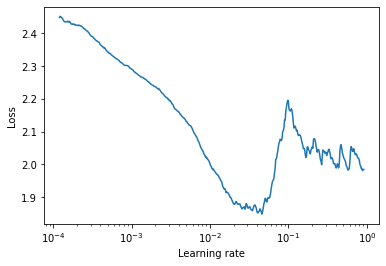

In [5]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()


In [6]:
lr_ = pd.DataFrame(lr_finder.history)
lr_max = lr_.loc[lr_['loss']==lr_['loss'].min(),'lr'].values[0]

In [7]:
net = ResNet18().to(device)
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr_max, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.413050651550293 Batch_id=199 Accuracy=35.16: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -2.6386, Accuracy: 4836/10000 (48.36%)

EPOCH: 1


Loss=1.279672384262085 Batch_id=199 Accuracy=48.96: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.0166, Accuracy: 5844/10000 (58.44%)

EPOCH: 2


Loss=1.0953714847564697 Batch_id=199 Accuracy=57.77: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.5716, Accuracy: 6722/10000 (67.22%)

EPOCH: 3


Loss=1.1027930974960327 Batch_id=199 Accuracy=63.17: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.2345, Accuracy: 6660/10000 (66.60%)

EPOCH: 4


Loss=0.99237459897995 Batch_id=199 Accuracy=67.06: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.7118, Accuracy: 7537/10000 (75.37%)

EPOCH: 5


Loss=0.9375889301300049 Batch_id=199 Accuracy=69.84: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.0278, Accuracy: 7461/10000 (74.61%)

EPOCH: 6


Loss=0.7879947423934937 Batch_id=199 Accuracy=71.65: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.5885, Accuracy: 7920/10000 (79.20%)

EPOCH: 7


Loss=0.7649877071380615 Batch_id=199 Accuracy=73.49: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.7966, Accuracy: 7793/10000 (77.93%)

EPOCH: 8


Loss=0.7840386629104614 Batch_id=199 Accuracy=75.06: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.3492, Accuracy: 8075/10000 (80.75%)

EPOCH: 9


Loss=0.7079132795333862 Batch_id=199 Accuracy=76.21: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.5603, Accuracy: 8271/10000 (82.71%)

EPOCH: 10


Loss=0.7821200489997864 Batch_id=199 Accuracy=77.02: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.8410, Accuracy: 8004/10000 (80.04%)

EPOCH: 11


Loss=0.6285508275032043 Batch_id=199 Accuracy=77.91: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.4848, Accuracy: 8315/10000 (83.15%)

EPOCH: 12


Loss=0.5161567330360413 Batch_id=199 Accuracy=78.50: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.9698, Accuracy: 8347/10000 (83.47%)

EPOCH: 13


Loss=0.6264729499816895 Batch_id=199 Accuracy=79.46: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.0290, Accuracy: 8318/10000 (83.18%)

EPOCH: 14


Loss=0.6442734003067017 Batch_id=199 Accuracy=80.32: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.9847, Accuracy: 8417/10000 (84.17%)

EPOCH: 15


Loss=0.6143091320991516 Batch_id=199 Accuracy=80.76: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.2610, Accuracy: 8530/10000 (85.30%)

EPOCH: 16


Loss=0.5614231824874878 Batch_id=199 Accuracy=80.87: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4677, Accuracy: 8602/10000 (86.02%)

EPOCH: 17


Loss=0.5168991088867188 Batch_id=199 Accuracy=81.41: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6071, Accuracy: 8691/10000 (86.91%)

EPOCH: 18


Loss=0.5214222073554993 Batch_id=199 Accuracy=81.82: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.8457, Accuracy: 8599/10000 (85.99%)

EPOCH: 19


Loss=0.5360885262489319 Batch_id=199 Accuracy=82.51: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4769, Accuracy: 8654/10000 (86.54%)

EPOCH: 20


Loss=0.5108650922775269 Batch_id=199 Accuracy=82.92: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6545, Accuracy: 8480/10000 (84.80%)

EPOCH: 21


Loss=0.5017915964126587 Batch_id=199 Accuracy=83.29: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.5965, Accuracy: 8565/10000 (85.65%)

EPOCH: 22


Loss=0.4282197952270508 Batch_id=199 Accuracy=83.72: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.7016, Accuracy: 8708/10000 (87.08%)

EPOCH: 23


Loss=0.43752971291542053 Batch_id=199 Accuracy=84.11: 100%|██████████| 200/200 [00:36<00:00,  5.48it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.8896, Accuracy: 8704/10000 (87.04%)

EPOCH: 24


Loss=0.46208709478378296 Batch_id=199 Accuracy=84.31: 100%|██████████| 200/200 [00:36<00:00,  5.47it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1130, Accuracy: 8765/10000 (87.65%)

EPOCH: 25


Loss=0.5424846410751343 Batch_id=199 Accuracy=84.37: 100%|██████████| 200/200 [00:36<00:00,  5.46it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6907, Accuracy: 8866/10000 (88.66%)

EPOCH: 26


Loss=0.5031880736351013 Batch_id=199 Accuracy=84.54: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6276, Accuracy: 8692/10000 (86.92%)

EPOCH: 27


Loss=0.41539332270622253 Batch_id=199 Accuracy=84.95: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.9096, Accuracy: 8805/10000 (88.05%)

EPOCH: 28


Loss=0.4942568242549896 Batch_id=199 Accuracy=84.94: 100%|██████████| 200/200 [00:36<00:00,  5.46it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0750, Accuracy: 8916/10000 (89.16%)

EPOCH: 29


Loss=0.42427223920822144 Batch_id=199 Accuracy=85.13: 100%|██████████| 200/200 [00:36<00:00,  5.44it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0726, Accuracy: 8908/10000 (89.08%)

EPOCH: 30


Loss=0.44033747911453247 Batch_id=199 Accuracy=85.38: 100%|██████████| 200/200 [00:36<00:00,  5.43it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.9648, Accuracy: 8872/10000 (88.72%)

Epoch    31: reducing learning rate of group 0 to 4.5848e-03.
EPOCH: 31


Loss=0.25935235619544983 Batch_id=199 Accuracy=89.07: 100%|██████████| 200/200 [00:36<00:00,  5.42it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4120, Accuracy: 9190/10000 (91.90%)

EPOCH: 32


Loss=0.34953561425209045 Batch_id=199 Accuracy=90.39: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7025, Accuracy: 9227/10000 (92.27%)

EPOCH: 33


Loss=0.2863321006298065 Batch_id=199 Accuracy=90.90: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.8470, Accuracy: 9218/10000 (92.18%)

EPOCH: 34


Loss=0.2505316138267517 Batch_id=199 Accuracy=91.26: 100%|██████████| 200/200 [00:37<00:00,  5.30it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.8777, Accuracy: 9250/10000 (92.50%)

EPOCH: 35


Loss=0.22559915482997894 Batch_id=199 Accuracy=91.64: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9974, Accuracy: 9237/10000 (92.37%)

EPOCH: 36


Loss=0.1918538361787796 Batch_id=199 Accuracy=91.92: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1458, Accuracy: 9249/10000 (92.49%)

EPOCH: 37


Loss=0.1866992861032486 Batch_id=199 Accuracy=92.08: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1765, Accuracy: 9250/10000 (92.50%)

EPOCH: 38


Loss=0.20446939766407013 Batch_id=199 Accuracy=91.99: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.2637, Accuracy: 9266/10000 (92.66%)

EPOCH: 39


Loss=0.18962301313877106 Batch_id=199 Accuracy=92.41: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3641, Accuracy: 9262/10000 (92.62%)

EPOCH: 40


Loss=0.20545785129070282 Batch_id=199 Accuracy=92.66: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.3713, Accuracy: 9260/10000 (92.60%)

EPOCH: 41


Loss=0.18531689047813416 Batch_id=199 Accuracy=92.82: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4664, Accuracy: 9280/10000 (92.80%)

EPOCH: 42


Loss=0.24817043542861938 Batch_id=199 Accuracy=92.90: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.4524, Accuracy: 9292/10000 (92.92%)

EPOCH: 43


Loss=0.19407670199871063 Batch_id=199 Accuracy=92.85: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.5869, Accuracy: 9310/10000 (93.10%)

EPOCH: 44


Loss=0.15017423033714294 Batch_id=199 Accuracy=93.10: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.5970, Accuracy: 9297/10000 (92.97%)

EPOCH: 45


Loss=0.1700797975063324 Batch_id=199 Accuracy=93.25: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7182, Accuracy: 9299/10000 (92.99%)

EPOCH: 46


Loss=0.2792353332042694 Batch_id=199 Accuracy=93.59: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.6878, Accuracy: 9262/10000 (92.62%)

EPOCH: 47


Loss=0.14871463179588318 Batch_id=199 Accuracy=93.28: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.7764, Accuracy: 9272/10000 (92.72%)

EPOCH: 48


Loss=0.2227911800146103 Batch_id=199 Accuracy=93.68: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.8496, Accuracy: 9303/10000 (93.03%)

EPOCH: 49


Loss=0.2021370381116867 Batch_id=199 Accuracy=93.65: 100%|██████████| 200/200 [00:37<00:00,  5.33it/s]



Test set: Average loss: -10.8234, Accuracy: 9293/10000 (92.93%)

Finished Training


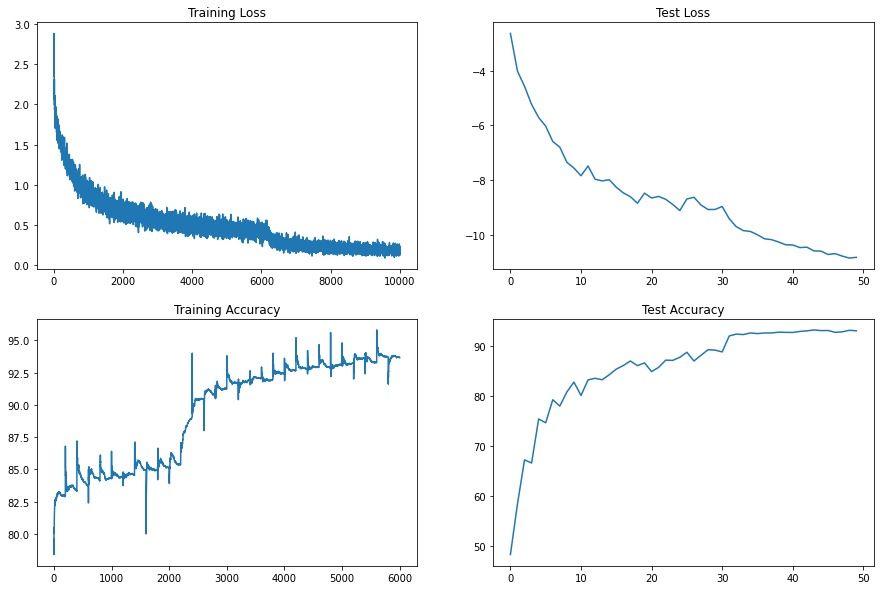

In [8]:
PlotTrainingGraphs(tt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


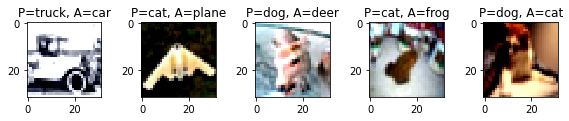

In [9]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
Misclassification(testloader,net,classes,device)

In [10]:
from gradcam import GradCamDisplay
import PIL
img_name =['airplane.png','automobile.png','bird.png','cat.png','deer.png']

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

FileNotFoundError: ignored

In [ ]:
from pylab import *
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images[:4]